Statistical Analysis

In [112]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
import contextily as ctx
from shapely.geometry import Point
import math
import numpy as np


load and clean data

In [113]:
main_data = pd.read_csv('../data/processed_data/chicago_il_processed.csv')
print(main_data.columns)
print(main_data['SquareFootage'])
main_data = main_data[['Latitude','Longitude','Neighborhood_Label','MaxRent','Beds','Baths','SquareFootage','ReviewScore']]

Index(['Address', 'Amenities', 'Neighborhood', 'NeighborhoodLink',
       'PropertyId', 'PropertyName', 'PropertyUrl', 'ReviewScore',
       'VerifiedListing', 'is_single_unit', 'Neighborhood_Label', 'Baths',
       'Beds', 'MaxRent', 'Model', 'SquareFootage', 'Latitude', 'Longitude'],
      dtype='object')
0        705
1        705
2        705
3        705
4        671
        ... 
6767     655
6768    1123
6769    1025
6770    1025
6771    1208
Name: SquareFootage, Length: 6772, dtype: object


In [114]:
# main_data = main_data.drop('PropertyId', axis=1)
# Ensure all data is numeric before calculating the correlation matrix
main_data = main_data.applymap(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
main_data = main_data.loc[:, ~main_data.apply(lambda col: col.astype(str).str.lower().eq('none').any())]

lower_cap = main_data['MaxRent'].quantile(0.00)
upper_cap = main_data['MaxRent'].quantile(0.995)
main_data['MaxRent'] = main_data['MaxRent'].clip(lower_cap, upper_cap)

/tmp/ipykernel_15605/2643194579.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  main_data = main_data.applymap(lambda x: pd.to_numeric(x, errors='coerce')).dropna()


General Statistics 

In [115]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(main_data.describe())


          Latitude    Longitude  Neighborhood_Label       MaxRent  \
count  6377.000000  6377.000000         6377.000000   6377.000000   
mean     41.890084   -87.648950           54.521562   3368.727878   
std       0.048389     0.068862           23.232376   1744.994862   
min      41.652527   -88.191527            1.000000    670.000000   
25%      41.871764   -87.654837           36.000000   2282.000000   
50%      41.885981   -87.635495           49.000000   2937.000000   
75%      41.899374   -87.624829           79.000000   4021.000000   
max      42.019639   -87.552543           93.000000  12803.240000   

              Beds        Baths  SquareFootage  ReviewScore  
count  6377.000000  6377.000000    6377.000000  6377.000000  
mean      1.037792     1.265956     796.883174     2.879583  
std       0.842143     0.517410     346.970105     2.340933  
min       0.000000     0.500000       1.000000     0.000000  
25%       0.000000     1.000000     583.000000     0.000000  
50%   

distribution of rent prices 

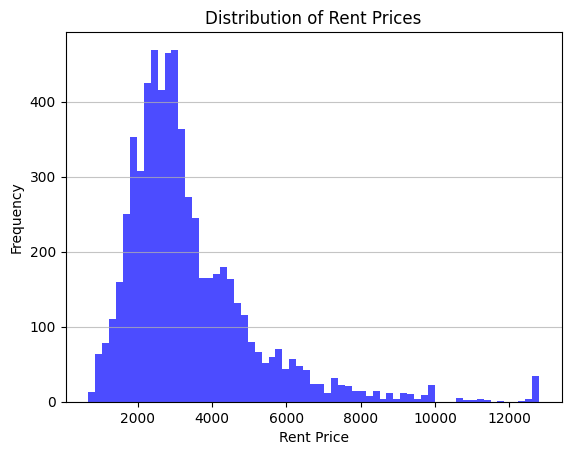

In [116]:

plt.hist(main_data['MaxRent'], bins='auto', color='blue', alpha=0.7)
plt.title('Distribution of Rent Prices')
plt.xlabel('Rent Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Linear Relationship between sqfoot and rent

Text(0.5, 1.0, 'Rent vs. Square Footage')

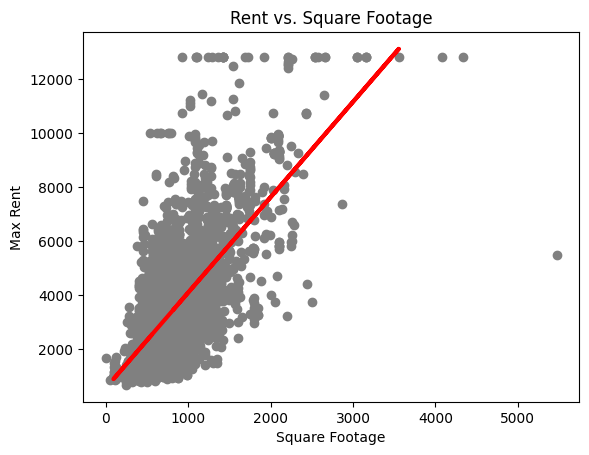

In [117]:
X = main_data[['SquareFootage']]
y = main_data['MaxRent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(main_data['SquareFootage'], main_data['MaxRent'], color='grey')
plt.plot(X_test, y_pred, color='red', linewidth=3, label='Predicted Rent')
plt.xlabel('Square Footage')
plt.ylabel('Max Rent')
plt.title('Rent vs. Square Footage')

Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

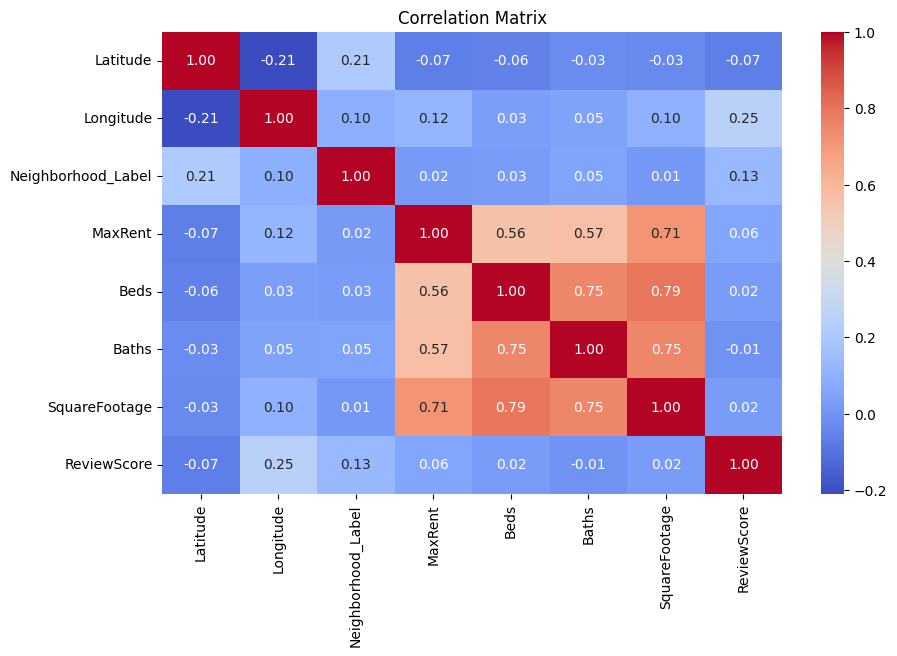

In [118]:
plt.figure(figsize=(10,6))
corr_matrix = main_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')


Visualizing Neighborhoods based on rent and amount

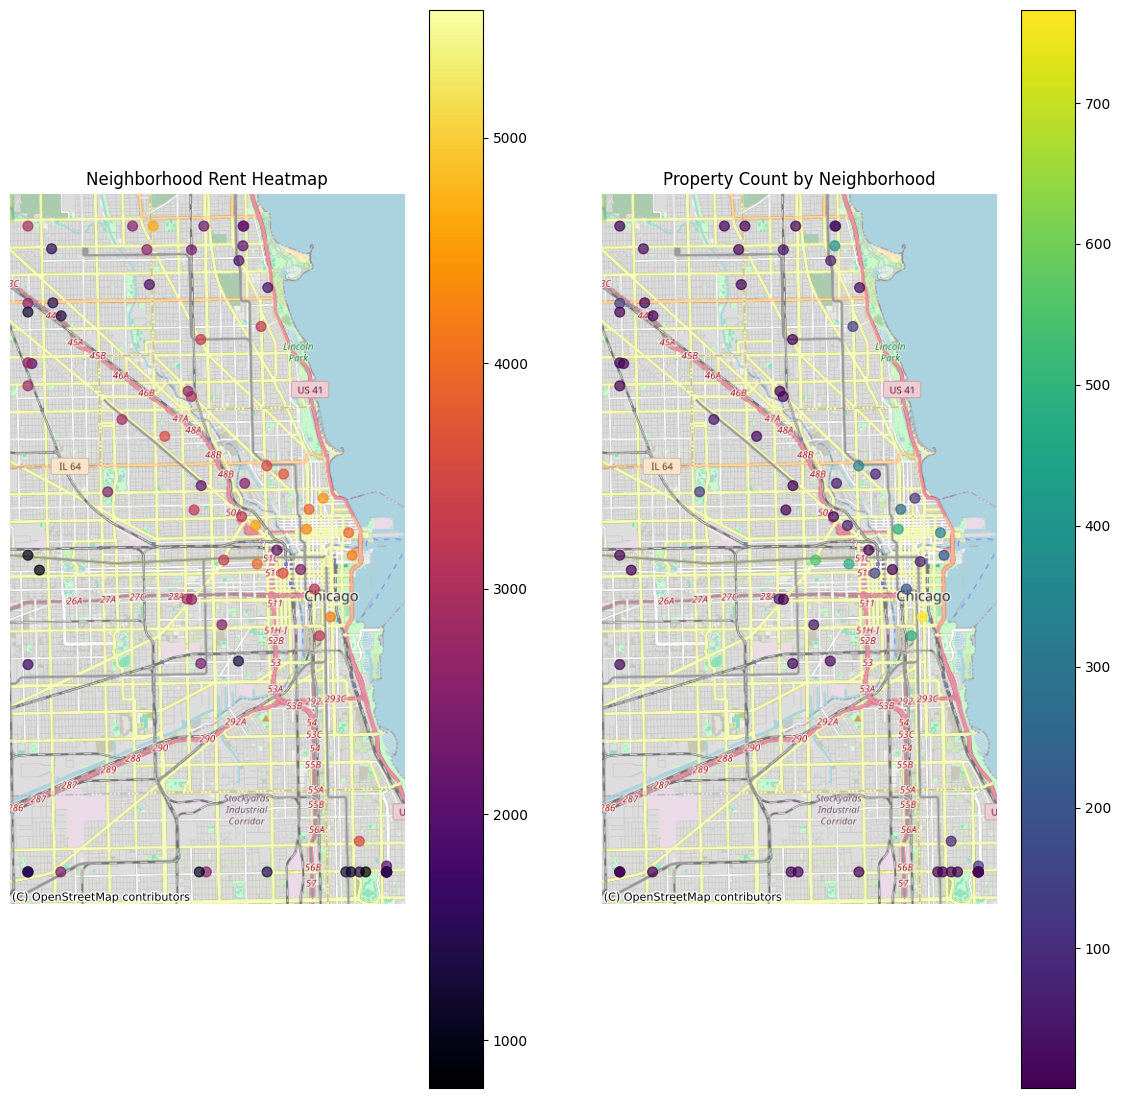

In [119]:
# Handle miscaculated lat long from addresses
lower_cap = main_data['Latitude'].quantile(0.05)
upper_cap = main_data['Latitude'].quantile(0.95)
main_data['Latitude'] = main_data['Latitude'].clip(lower_cap, upper_cap)

lower_cap = main_data['Longitude'].quantile(0.05)
upper_cap = main_data['Longitude'].quantile(0.95)
main_data['Longitude'] = main_data['Longitude'].clip(lower_cap, upper_cap)

# Get meta-data for neighborhoods
neighborhoods = main_data.groupby('Neighborhood_Label').agg(
    MaxRent_Mean=('MaxRent', 'mean'),
    MaxRent_Std=('MaxRent', 'std'),
    Latitude_Mean=('Latitude', 'mean'),
    Longitude_Mean=('Longitude', 'mean'),
    Property_Count=('Neighborhood_Label', 'size')
)

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(neighborhoods['Longitude_Mean'], neighborhoods['Latitude_Mean'])]
gdf = gpd.GeoDataFrame(neighborhoods, geometry=geometry)
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))

# Plot 1: Heatmap based on MaxRent_Mean
gdf.plot(ax=ax1, marker='o', column='MaxRent_Mean', cmap='inferno', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
ax1.set_title('Neighborhood Rent Heatmap')

# Plot 2: Heatmap based on Property_Count
gdf.plot(ax=ax2, marker='o', column='Property_Count', cmap='viridis', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_axis_off()
ax2.set_title('Property Count by Neighborhood')


plt.show()